In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn
from tensorflow import keras

In [2]:
df_BYDATE = pd.read_csv('/storage/data/ad_matched_queries_20190831__by_date.csv')
df_BYDATE['created_transactions'] = df_BYDATE['created_accounts'] + df_BYDATE['transactions']
df_BYDATE.head(10)

#df_AGG = pd.read_csv('ad_matched_queries_AGG.csv')
#df_AGG

,campaign_label,date,source_medium,campaign,ad_group,ad_matched_query,ad_cost,impressions,clicks,users,new_users,sessions,bounces,created_accounts,transactions,transaction_revenue,created_transactions
0,brand,2017-03-07,google / cpc,Brand Terms,Paperspace For Teams,paper space,0.31,4,1,1,1,1,0,0,0,0.0,0
1,brand,2017-03-07,google / cpc,Brand Terms,Paperspace For Teams,paperspace,1.06,28,5,4,3,4,2,0,0,0.0,0
2,brand,2017-03-08,google / cpc,Brand Terms,Paperspace For Teams,paperspace,0.94,24,3,1,0,1,0,0,0,0.0,0
3,brand,2017-03-09,google / cpc,Brand Terms,Paperspace For Teams,paperspace,1.70,50,4,2,2,2,1,0,0,0.0,0
4,brand,2017-03-10,google / cpc,Brand Terms,Paperspace For Teams,paperspace,4.57,49,7,5,4,9,0,1,1,6.0,2
5,brand,2017-03-11,google / cpc,Brand Terms,Paperspace For Teams,paperspace,1.22,14,2,3,2,7,0,0,0,0.0,0
6,brand,2017-03-12,google / cpc,Brand Terms,Paperspace For Teams,paperspace,1.62,28,2,4,1,7,4,0,0,0.0,0
7,brand,2017-03-13,google / cpc,Brand Terms,Paperspace For Teams,paperspace,6.81,24,9,6,2,9,0,0,0,0.0,0
8,brand,2017-03-14,google / cpc,Brand Terms,Paperspace For Teams,paperspace,5.56,37,8,7,3,7,4,0,0,0.0,0
9,brand,2017-03-15,google / cpc,Brand Terms,Paperspace For Teams,paperspace,2.51,48,3,5,4,7,1,1,1,15.0,2


In [ ]:
## keywords dataset
#df_keywords = pd.read_csv('Search keyword report 20190916.csv')
#df_keywords

In [ ]:
#df_BYDATE['transaction/clicks'] = df_BYDATE['transactions'] / df_BYDATE['clicks']

In [3]:
df_BYDATE['created_transactions'].value_counts()

0     173321
1      12399
2       2010
3        603
4        285
5        167
6         62
7         41
8         22
9         10
12         7
10         6
18         2
11         2
17         2
13         1
15         1
16         1
20         1
Name: created_transactions, dtype: int64

In [4]:
# Turn into binary variable
#df_BYDATE['create_account1'] = np.where(df_BYDATE["created_accounts"] > 0, 1, 0)
#df_BYDATE['create_account1'].value_counts()

In [ ]:
#query_train, query_val, created_train, created_val = train_test_split(query_train, created_train, test_size=0.2, random_state=1)

# when do to tokenization? for bag of words, create matrix ASAP--preprocess everything before traintestsplit
# merge transaction and created account
# impressions, clicks

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

t = Tokenizer(num_words=20000)
t.fit_on_texts(df_BYDATE['ad_matched_query'])

#print(t.word_counts)
#print(t.document_count)
#print(t.word_index)
#print(t.word_docs)

In [6]:
sequenced_queries = t.texts_to_sequences(df_BYDATE['ad_matched_query'])
#sequenced_queries

In [ ]:
#encoded_queries = t.texts_to_matrix(df_BYDATE['ad_matched_query'], mode='binary')
#print(encoded_queries)

In [7]:
from keras_preprocessing import sequence

max_length = len(max(sequenced_queries, key=len))

padded_sequences = sequence.pad_sequences(sequenced_queries, maxlen=max_length)

padded_sequences.shape
#t.word_index

(188943, 29)

In [8]:
Y = pd.get_dummies(df_BYDATE['created_transactions']).values
Y.shape

(188943, 19)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(padded_sequences, Y,test_size=0.2, random_state=42)
print(X_train.shape,Y_train.shape)
#print(X_test.shape,Y_test.shape)

(151154, 29) (151154, 19)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

# The maximum number of words to be used.
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 100

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=padded_sequences.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(19, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 29, 100)           1000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 29, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 19)                1919      
Total params: 1,082,319
Trainable params: 1,082,319
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 136038 samples, validate on 15116 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
136038/136038 [==============================] - 327s 2ms/sample - loss: 0.3303 - acc: 0.9175 - val_loss: 0.3157 - val_acc: 0.9153
Epoch 2/10
136038/136038 [==============================] - 324s 2ms/sample - loss: 0.3051 - acc: 0.9180 - val_loss: 0.3063 - val_acc: 0.9153
Epoch 3/10
136038/136038 [==============================] - 323s 2ms/sample - loss: 0.3003 - acc: 0.9180 - val_loss: 0.3053 - val_acc: 0.9153
Epoch 4/10
136038/136038 [==============================] - 324s 2ms/sample - loss: 0.2967 - acc: 0.9180 - val_loss: 0.3038 - val_acc: 0.9153
Epoch 5/10
136038/136038 [==============================] - 333s 2ms/sample - loss: 0.2940 - acc: 0.9181 - val_loss: 0.3018 - val_acc: 0.9153
Epoch 6/10
136038/136038 [==============================] - 324s 2ms/sample - loss: 0.2918 - acc: 0.9181 - val_loss: 0.3037 - val_acc: 0.9153
Epoch 7/10
136038/136038 [=======================

In [15]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

37789/37789 [==============================] - 44s 1ms/sample - loss: 0.3101 - acc: 0.9152
Test set
  Loss: 0.310
  Accuracy: 0.915


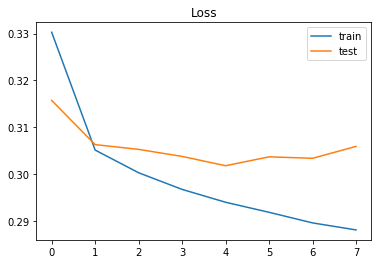

In [17]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


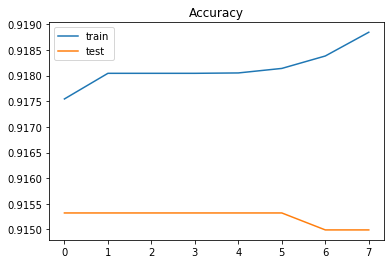

In [18]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [19]:
new_query = ['Paperspace windows GPU']
seq = t.texts_to_sequences(new_query)
padded = sequence.pad_sequences(seq, maxlen=29)
pred = model.predict(padded)
labels = df_BYDATE['created_transactions'].value_counts()
print(pred, labels[np.argmax(pred)])

[[9.5373094e-01 4.4330407e-02 1.8797070e-03 5.5888639e-05 2.0284992e-06
  1.0293434e-06 4.9809832e-09 8.3492333e-09 7.4397065e-11 1.9262517e-11
  8.2270217e-09 6.6104995e-12 3.5796637e-09 1.3491934e-10 1.7914850e-08
  2.3500993e-10 4.5926658e-08 7.0340054e-09 5.4016572e-11]] 173321
